# Sheet 7

Johannes van de Locht, Finn Kalvelage, Anna Beckers

## Task 1

In [63]:
%pip install networkx
%pip install openpyxl
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [64]:
# a)
import pandas as pd


df = pd.read_excel("breast-cancer-wisconsin.xlsx")
df.head()

,code,thickness,uniCelS,uniCelShape,marAdh,epiCelSize,bareNuc,blaChroma,normNuc,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [65]:
# fill in missing values like on sheet 3
df['bareNuc'] = df['bareNuc'].fillna(df['bareNuc'].mode()[0])
df.isna().any()

code           False
thickness      False
uniCelS        False
uniCelShape    False
marAdh         False
epiCelSize     False
bareNuc        False
blaChroma      False
normNuc        False
mitoses        False
class          False
dtype: bool

In [66]:
# calculate pearson correlation between every pair of variables
correlation_matrix = df.corr(method='pearson')
print(correlation_matrix)

                 code  thickness   uniCelS  uniCelShape    marAdh  epiCelSize  \
code         1.000000  -0.055308 -0.041603    -0.041576 -0.064878   -0.045528   
thickness   -0.055308   1.000000  0.644913     0.654589  0.486356    0.521816   
uniCelS     -0.041603   0.644913  1.000000     0.906882  0.705582    0.751799   
uniCelShape -0.041576   0.654589  0.906882     1.000000  0.683079    0.719668   
marAdh      -0.064878   0.486356  0.705582     0.683079  1.000000    0.599599   
epiCelSize  -0.045528   0.521816  0.751799     0.719668  0.599599    1.000000   
bareNuc     -0.092533   0.590008  0.686673     0.707474  0.666971    0.583701   
blaChroma   -0.060051   0.558428  0.755721     0.735948  0.666715    0.616102   
normNuc     -0.052072   0.535835  0.722865     0.719446  0.603352    0.628881   
mitoses     -0.034901   0.350034  0.458693     0.438911  0.417633    0.479101   
class       -0.080226   0.716001  0.817904     0.818934  0.696800    0.682785   

              bareNuc  blaC

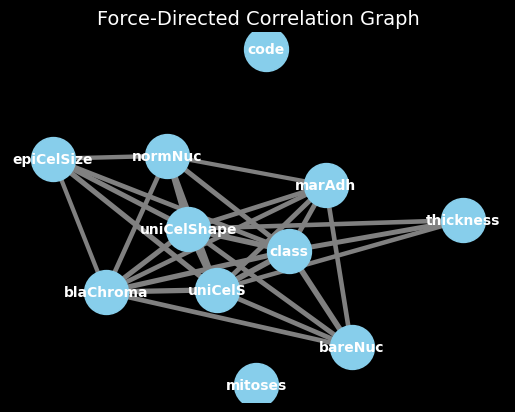

In [67]:
# b)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()

# add all nodes (so disconnected ones are included)
G.add_nodes_from(correlation_matrix.columns)

# nodes and edges based on correlation threshold phi > 0.6
threshold = 0.6
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j:
            weight = correlation_matrix.loc[i, j]
            if abs(weight) >= threshold:
                G.add_edge(i, j, weight=weight)

# graph with force-directed layout (parameters set so disconnected nodes are relatively close)
pos = nx.spring_layout(
    G,
    k=1,            # lower = tighter spacing
    iterations=25,   # higher = more convering
    seed=42,
    scale=2.0,        
    center=(0, 0)     
)

# Edge colors & widths based on weight
edges = G.edges(data=True)
weights = [abs(data['weight']) for _, _, data in edges]


# nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue')
# edges
nx.draw_networkx_edges(G, pos, width=[w * 5 for w in weights], edge_color='gray')

# node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white')


plt.title("Force-Directed Correlation Graph", fontsize=14)
plt.axis('off')
plt.show()



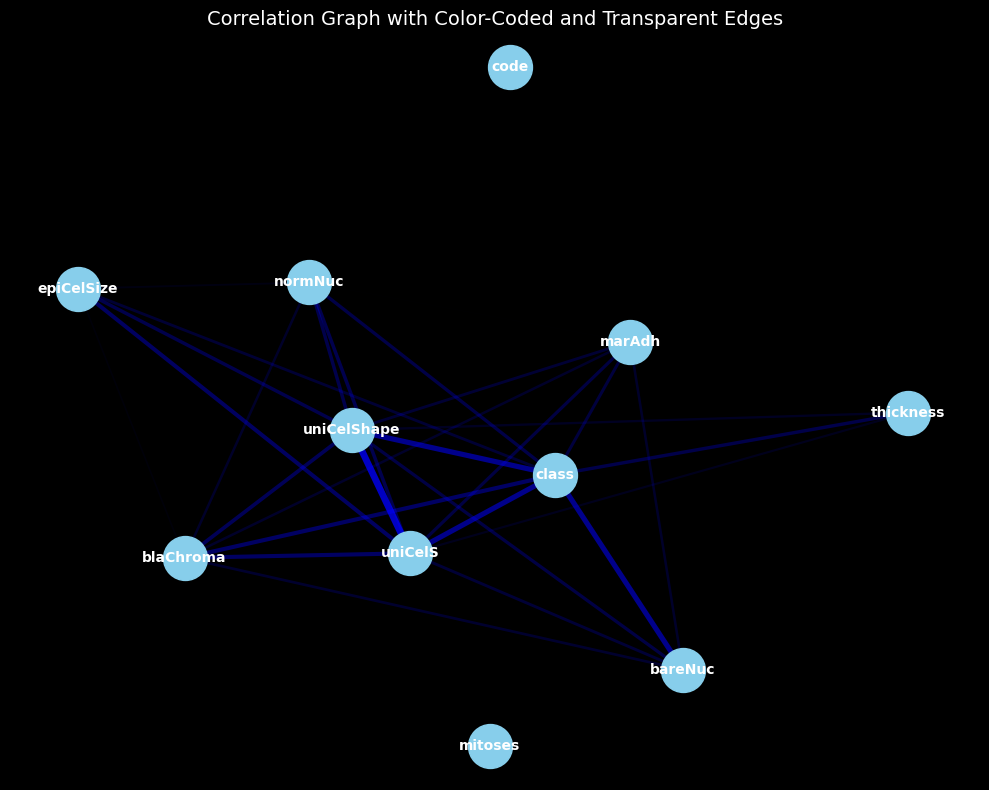

In [68]:
# c)

#correlation matrix
corr = df.corr(method='pearson')

# graph from correlation matrix
G = nx.Graph()

# add all nodes (so disconnected ones are included)
G.add_nodes_from(correlation_matrix.columns)

# add edges
threshold = 0.6  
for i in corr.columns:
    for j in corr.columns:
        if i != j:
            weight = corr.loc[i, j]
            if abs(weight) >= threshold:
                G.add_edge(i, j, weight=weight)

# force-directed layout with hyperparameters
pos = nx.spring_layout(
    G,
    k=1,            # lower = tighter spacing
    iterations=25,   # higher = more convering
    seed=42,
    scale=2.0,
    center=(0, 0)
)

# edge visuals
edges = G.edges(data=True)
edge_colors = ['blue' if d['weight'] > 0 else 'red' for _, _, d in edges]

# make differences in edge width / transparency more pronounced
min_corr, max_corr = threshold, 1.0

def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

edge_alphas = [normalize(abs(d['weight']), min_corr, max_corr) for _, _, d in edges]
edge_widths = [1 + normalize(abs(d['weight']), min_corr, max_corr) * 5 for _, _, d in edges]




fig, ax = plt.subplots(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', ax=ax)

# edges with color and alpha
for (u, v, d), color, alpha, width in zip(edges, edge_colors, edge_alphas, edge_widths):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        width=width,
        edge_color=color,
        alpha=alpha,
        ax=ax
    )

# node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white', ax=ax)

# edge labels (correlation values)
# edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=9, ax=ax)


plt.title("Correlation Graph with Color-Coded and Transparent Edges", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


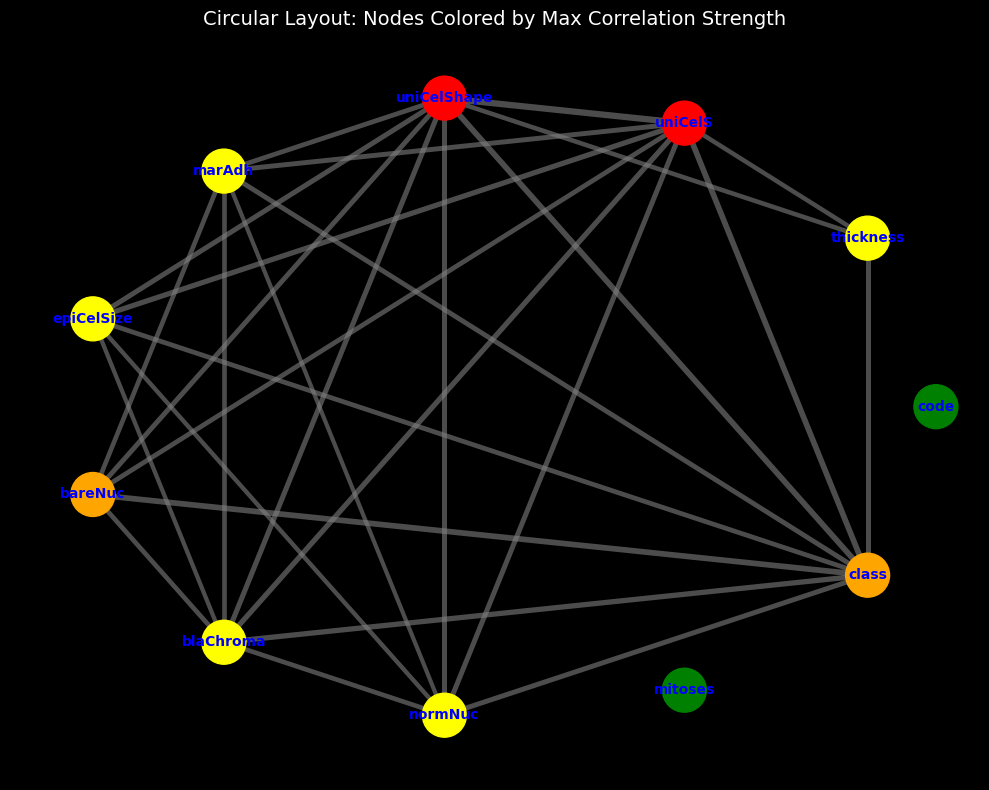

In [69]:
# d) visualization with circular layout

# correlation matrix
corr = df.corr(method='pearson')

# undirected graph
G = nx.Graph()

# add all nodes (so disconnected ones are included)
G.add_nodes_from(correlation_matrix.columns)

# add edges
threshold = 0.6
for i in corr.columns:
    for j in corr.columns:
        if i != j:
            weight = corr.loc[i, j]
            if abs(weight) >= threshold:
                G.add_edge(i, j, weight=weight)

# maximum correlation per node
max_corr = {}
for col in corr.columns:
    # exclude self-correlation by masking the diagonal
    others = corr.loc[col].drop(labels=[col])
    max_val = others.abs().max()
    max_corr[col] = max_val

# assign color based on max correlation bucket
def get_color(rho):
    if rho > 0.9:
        return 'red'
    elif rho > 0.8:
        return 'orange'
    elif rho > 0.6:
        return 'yellow'
    else:
        return 'green'

node_colors = [get_color(max_corr[node]) for node in G.nodes]

# circular layout
pos = nx.circular_layout(G)

# graph
fig, ax = plt.subplots(figsize=(10, 8))

# nodes with computed colors
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=node_colors, ax=ax)

# edges
edges = G.edges(data=True)
weights = [abs(d['weight']) * 5 for _, _, d in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.6, ax=ax)

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='blue', ax=ax)

# edge labels 
# edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=9, ax=ax)


plt.title("Circular Layout: Nodes Colored by Max Correlation Strength", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


### e)
#### At the selected threshold, which nodes are disconnected from the rest of the graph and what do they indicate? 

- At the threshold of 0.6 the nodes mitoses and code are disconnected to the graph. This means they both have a low correlation to the other factors. This makes sense as the code is just a unique identifing number for each datapoint, and thus has no intrinsic information. 
The mitosis column / node measures the mitotic activity / cell devision in the sample. Here it is not so obvious why there is no high linear correlation to any of the other factors.

#### If two nodes A and B are strongly correlated, and node C is strongly correlated with node B, can we conclude that node C will be also strongly correlated with node A? 
- No this cannot be guaranteed as the pearson correlation is not transitive.

#### Based on the visualization, which variables would you propose to predict the class?
- The visualization shows high correlation between 'uniCelShape', 'bareNuc',  'uniCelS' and 'class' thus these three variables would be the most important ones to predict the class.

## Task 2

### a) What is the difference between geometric zoom and detail zoom in the system?

Geometric zoom maps a part of the adjacency matrix from the current detail level to the viewport. This can be navigated by the user through zooming in and out (changing the amount of cells displayed in the viewport) or through horizontal and vertical translation. This makes the geometric zoom continious.

The detail zoom switches through the different detail levels and is therefore discrete.

### b) The paper suggests eight different ways to visualize aggregated edge information. Which of them are actually used in the screenshots in Figures 1 and 9? 

The images in figure 1 both use *step histograms* for cells with edges while the left image of figure 9 uses the *average* visualization and the right image looks like it uses *color shading* though the used color shows no differences between cells.

### c) What is the role of tile management within the ZAME system? What is an LRU cache? 

As the data structure (especially for bigger datasets) can be to large for the RAM or VRAM (atleast at the time of the release of the paper) not the complete adjacency matrix let alone each detail level could be present in the cache (RAM or VRAM). The tile manager is used for the loading the correct detail level and has the ability to temporarily present a lower detail level during the loading process. The policy for choosing which tiles to keep in the caches is the least recently used (LRU) policy which discards the tile that wasn't used for the longest when a new tile needs to be cached and the cache is already full.

### d) How does ZAME aggregate nominal attributes? Why is that problematic?

As there is no immediatly obvious way for nominal attributes to be aggregated ZAME uses the first label that represents the whole aggregate. This method fails to capture the diversity of the whole aggregate and can also be quite arbitrary depending on the ordering of labels.

### e) Why is the Traveling Salesman Problem relevant to adjacency matrix based graph visualization?

ZAME uses an aproximation algorithm for the TSP to find good orderings of adjacency matrices for graphs with relativly dissimilar weighted edges. The desired ordering of vertices to build good local structures probably arises from the need to travel to each vertex of a highly interconnected cluster in quick succession to achieve the shortest route.

### f) In the pseudocode listed in the paper’s Figure 4, some modifications are highlighted in boldface, on lines starting with a bar. What is the purpose of these modifications?

The bold-faced parts of the algorithm exist to spread the pivot point equally around the subtrees. Without the penalization the algorithm would prioritize the 2 largest subtrees and therefore misrepresent the rest of the data.

## Task 3

In [ ]:
from dash import Dash, html, State, dcc, callback, Output, Input
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE

In [2]:
df = pd.read_excel('Data_Cortex_Nuclear.xls').dropna()
df_filt = df[df['class'].isin(['t-CS-s', 'c-CS-s'])].reset_index(drop=True)
classes = df_filt['class']
df_filt = df_filt.drop(columns=['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'])

df_filt_classes = df_filt.copy()
df_filt_classes['class'] = classes

In [3]:
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_filt))
df_pca['class'] = classes

iso = Isomap(n_neighbors=8)
df_iso = pd.DataFrame(iso.fit_transform(df_filt))
df_iso['class'] = classes

tsne = TSNE(perplexity=5.0)
df_tsne = pd.DataFrame(tsne.fit_transform(df_filt))
df_tsne['class'] = classes

In [4]:
app = Dash()

In [5]:
reduc_methods = html.Div([
                dcc.RadioItems(
                    options=[
                        {'label': 'PCA', 'value': 'PCA'},
                        {'label': 'ISOMAP', 'value': 'ISOMAP'},
                        {'label': 't-SNE', 'value': 't-SNE'}
                    ],
                    value='PCA',
                    id='dim_reduc_method',
                    labelStyle={'display': 'inline-block', 'margin-right': '10px'}
                )
            ], style={
                'display': 'flex',
                'justifyContent': 'center',
                'alignItems': 'center',
                'width': '50%'
            })

dropdown_1 = html.Div([
                    html.Div("x-Axis", style={'textAlign': 'center', 'fontWeight': 'bold', 'marginBottom': '2px'}),
                    dcc.Dropdown(
                        options=[{'label': col, 'value': col} for col in df_filt.columns],
                        value=df_filt.columns[0],
                        id='dropdown_1',
                        clearable=False,
                        style={'width': '200px'}
                    )
                ], style={'margin': '5px'})

dropdown_2 = html.Div([
                    html.Div("y-Axis", style={'textAlign': 'center', 'fontWeight': 'bold', 'marginBottom': '2px'}),
                    dcc.Dropdown(
                        options=[{'label': col, 'value': col} for col in df_filt.columns],
                        value=df_filt.columns[1],
                        id='dropdown_2',
                        clearable=False,
                        style={'width': '200px'}
                    )
                ], style={'margin': '5px'})

button = html.Button(
                    "Add",
                    id='add_button',
                    n_clicks=0,
                    style={'height': '35px', 'margin': '5px', 'alignSelf': 'flex-end'}
                )

options = html.Div([
            reduc_methods,
        
            html.Div([
                dropdown_1,
                dropdown_2,
                button
            ], style={
                'display': 'flex',
                'flexDirection': 'row',
                'justifyContent': 'center',
                'alignItems': 'flex-end',
                'width': '50%'
            })
        ], style={
            'display': 'flex',
            'flexDirection': 'row',
            'marginBottom': '20px'
        })

In [6]:
graphs_top = html.Div([dcc.Graph(figure={}, id='dim_reduc_graph', style={'width': '50%'}),
                       dcc.Graph(figure={}, id='map_ind_feats', style={'width': '50%'})], 
                      style={'display': 'flex', 'justifyContent': 'space-between', 'gap': '20px'})

In [7]:
@callback(
    Output(component_id='dim_reduc_graph', component_property='figure'),
    Input(component_id='dim_reduc_method', component_property='value')
)
def update_vis(meth_chosen):
    if meth_chosen == 'PCA':
        fig = px.scatter(df_pca, x=0, y=1, color='class', title="PCA Projection")
        fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))
    elif meth_chosen == 'ISOMAP':
        fig = px.scatter(df_iso, x=0, y=1, color='class', title="ISOMAP Projection")
        fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))
    elif meth_chosen == 't-SNE':
        fig = px.scatter(df_tsne, x=0, y=1, color='class', title="t-SNE Projection")
        fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))
    else:
        fig = {}
    return fig

In [8]:
@callback(
    Output(component_id='map_ind_feats', component_property='figure'),
    Input(component_id='dropdown_1', component_property='value'),
    Input(component_id='dropdown_2', component_property='value')
)
def map_features(col1, col2):
    fig = px.scatter(df_filt_classes, x=col1, y=col2, color='class')
    return fig

In [9]:
graph_bottom_storage = dcc.Store(id='plot_history', data=[])
graph_bottom_cont = html.Div(id='history_plots_container')

In [10]:
@callback(
    Output(component_id='plot_history', component_property='data'),
    Input(component_id='add_button', component_property='n_clicks'),
    State(component_id='dropdown_1', component_property='value'),
    State(component_id='dropdown_2', component_property='value'),
    State(component_id='plot_history', component_property='data')
)
def add_plot(n_clicks, col1, col2, plot_hist):
    if n_clicks > 0:
        fig = px.scatter(df_filt_classes, x=col1, y=col2, color='class')
        new_plot = fig.to_dict()
        plot_hist.append(new_plot)
        if len(plot_hist) > 4:
            plot_hist = plot_hist[-4:]
    return plot_hist

In [11]:
@callback(
    Output('history_plots_container', 'children'),
    Input('plot_history', 'data')
)
def vis_plot_hist(plot_history):
    if not plot_history:
        return []

    plots = [
        dcc.Graph(
            figure=go.Figure(fig),
            style={
                'width': '22%',
                'aspectRatio': '1',
                'margin': '10px'
            }
        ) for fig in plot_history
    ]

    return html.Div(
        children=plots,
        style={
            'display': 'flex',
            'justifyContent': 'center',
            'alignItems': 'center',
            'gap': '10px',
            'overflowX': 'auto'
        }
    )

In [12]:
app.layout = html.Div([
    graph_bottom_storage,
    
    html.H2('Interactive Visualization with Dash', style={'textAlign': 'center'}),
    html.Hr(),
    options,
    graphs_top,
    graph_bottom_cont
])      

if __name__ == '__main__':
    app.run(jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/
